In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys,os
sys.path.append(os.path.abspath(os.path.join("..")))
from config import *
import umap 
from sklearn.model_selection import KFold
import numpy as np

/mnt/c/Users/Lenovo/Documents/project/capstone_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(vcf_path+"/GenotypeCounts_PRS.csv")
df.drop(columns=['patient_id','IL10RA','RELA','TAGAP','PTAFR','IL23R','SDF2L1','PTPN22','SLC39A8','HGFAC','DOK2','CCR7','FUT2','LACC1'],inplace=True)
labels = df['label']

In [3]:
df

,ATG16L1,NOD2,CARD9,label,PRS
0,2,1,1,0,0.028265
1,1,0,2,1,0.024430
2,1,0,0,1,0.017174
3,1,0,2,0,0.024559
4,2,0,1,0,0.026996
...,...,...,...,...,...
106,2,0,1,0,0.013530
107,0,0,0,1,0.015185
108,0,0,1,0,0.015098
109,0,0,2,1,0.031139


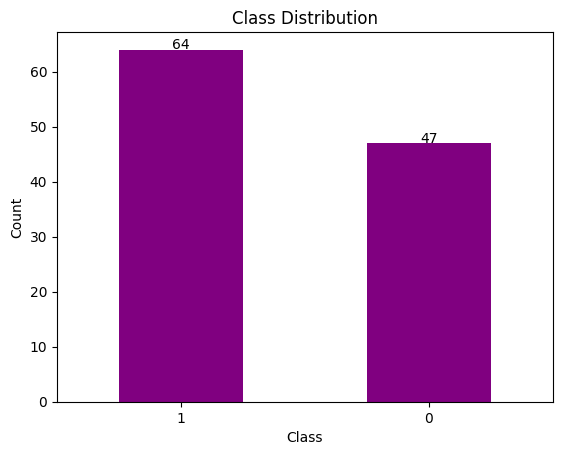

In [4]:
class_counts = df['label'].value_counts()
ax = class_counts.plot(kind='bar', color='purple', rot=0)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
for i, count in enumerate(class_counts):
    ax.text(i, count + 0.1, str(count), ha='center')
plt.show()

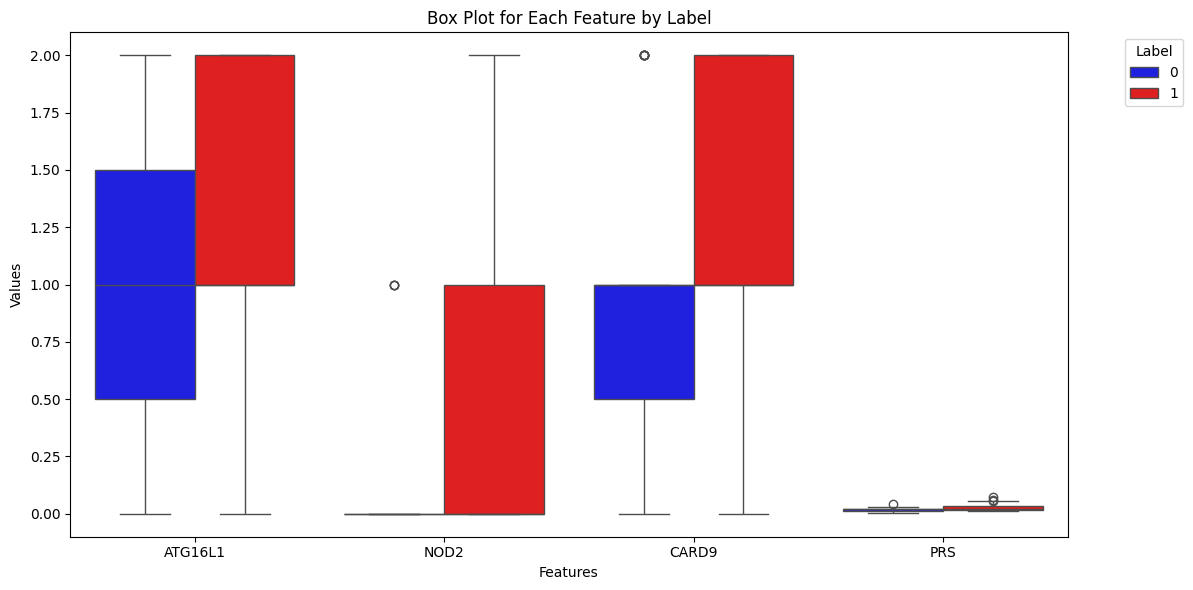

In [ ]:
df_melted = df.melt(id_vars='label', var_name='Feature', value_name='Value')
palette = {0: 'blue', 1: 'red'}
plt.figure(figsize=(12, 6))
sns.boxplot(x='Feature', y='Value', hue='label', data=df_melted, palette=palette)
plt.title('Box Plot for Each Feature by Label')
plt.xlabel('Features')
plt.ylabel('Values')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() 
plt.show()

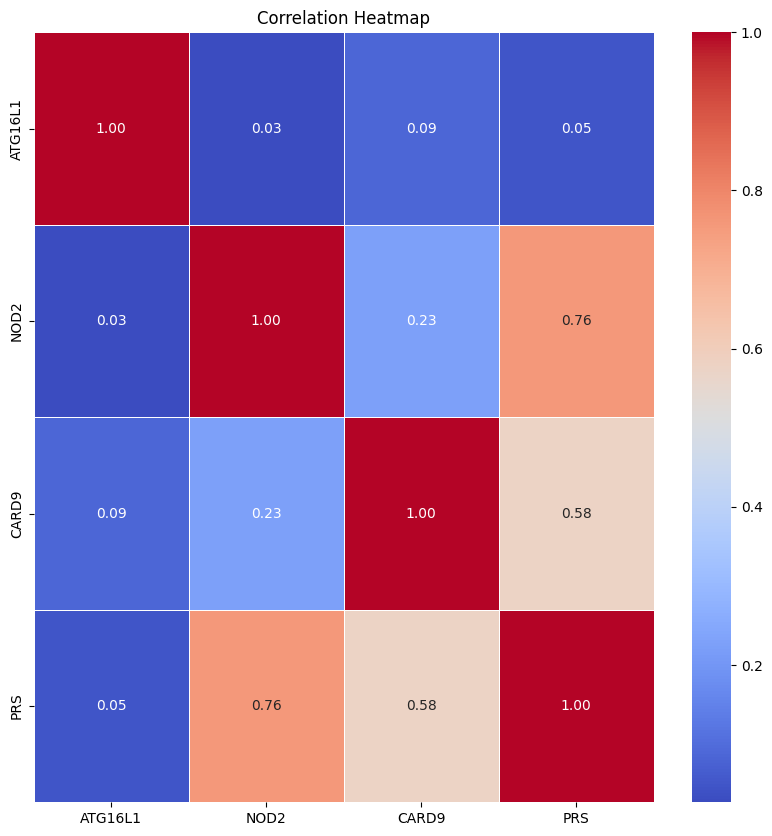

In [6]:
corr = df.drop(columns=['label']).corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

/mnt/c/Users/Lenovo/Documents/project/capstone_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


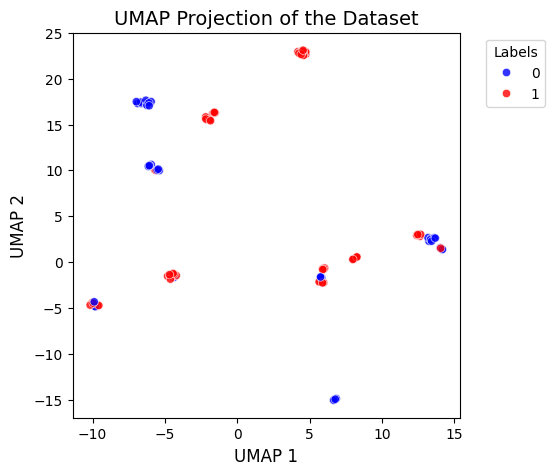

In [ ]:
label = df['label']
reducer = umap.UMAP(metric='euclidean')
embedding = reducer.fit_transform(df.drop(columns=['label']))
plt.figure(figsize=(5, 5))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=label, palette=palette, alpha=0.8)
plt.title('UMAP Projection of the Dataset', fontsize=14)
plt.xlabel('UMAP 1', fontsize=12)
plt.ylabel('UMAP 2', fontsize=12)
plt.legend(title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


splitting

In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['label']) 
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

Training set size: (88, 4), Testing set size: (23, 4)


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

logistic regression

Accuracy: 52.1739

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.55      0.92      0.69        13

    accuracy                           0.52        23
   macro avg       0.27      0.46      0.34        23
weighted avg       0.31      0.52      0.39        23



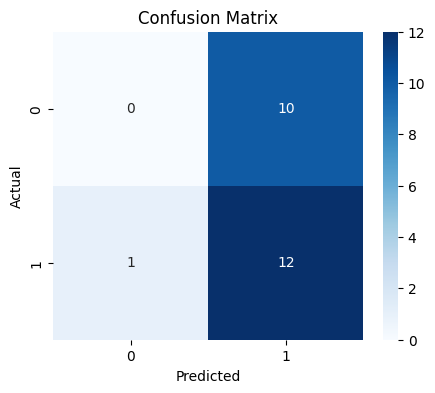

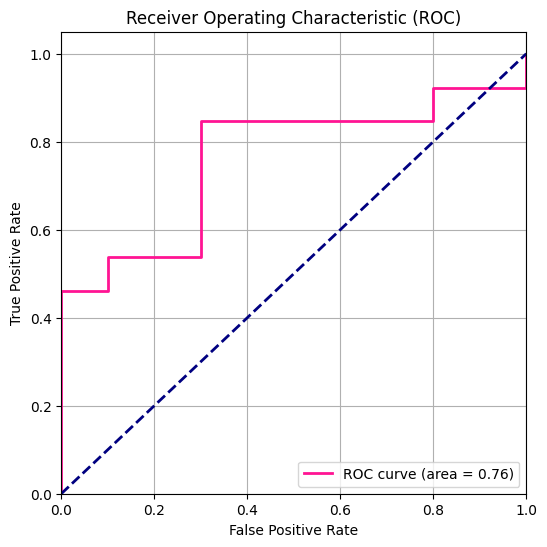

In [ ]:
# Initialize and train logistic regression model
logistic = LogisticRegression(random_state=42)
logistic.fit(X_train, y_train)
# Make predictions
y_pred = logistic.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=logistic.classes_, yticklabels=logistic.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
y_probs = logistic.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='deeppink', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [26]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = LogisticRegression(random_state=42)

accuracies = []
aucs = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_test_fold)
    y_prob = model.predict_proba(X_test_fold)[:, 1]

    acc = accuracy_score(y_test_fold, y_pred)
    roc = roc_auc_score(y_test_fold, y_prob)
    
    accuracies.append(acc)
    aucs.append(roc)

print(f"\nAverage Accuracy: {np.mean(accuracies)*100:.4f}")
print(f"Average AUC: {np.mean(aucs):.4f}")


Average Accuracy: 60.3268
Average AUC: 0.6881


svm

Accuracy: 91.3043

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.87      1.00      0.93        13

    accuracy                           0.91        23
   macro avg       0.93      0.90      0.91        23
weighted avg       0.92      0.91      0.91        23



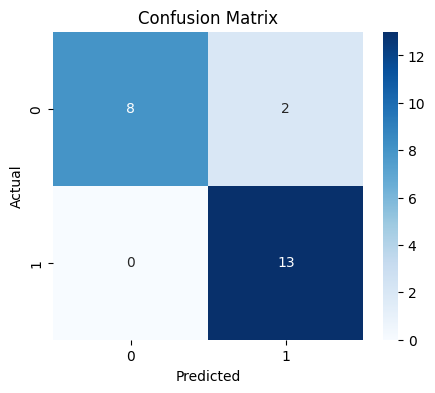

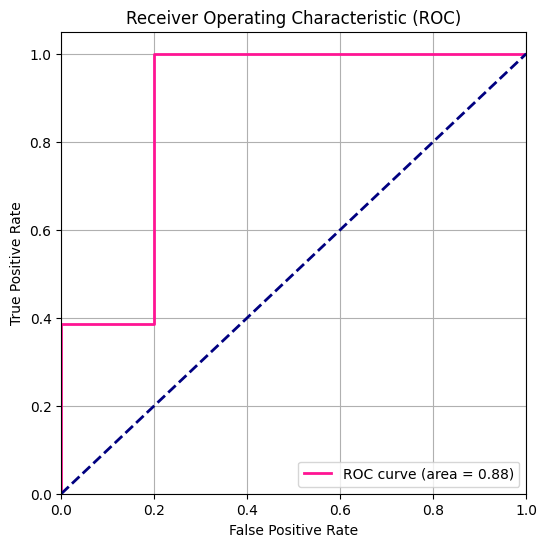

In [ ]:
svm_model = SVC( kernel='rbf', C=100, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


y_probs = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='deeppink', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [28]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = SVC(kernel='rbf', C=100, gamma='scale', probability=True, random_state=42)

accuracies = []
aucs = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_test_fold)
    y_prob = model.predict_proba(X_test_fold)[:, 1]

    acc = accuracy_score(y_test_fold, y_pred)
    roc = roc_auc_score(y_test_fold, y_prob)
    
    accuracies.append(acc)
    aucs.append(roc)
print(f"\nAverage Accuracy: {np.mean(accuracies)*100:.4f}")
print(f"Average AUC: {np.mean(aucs):.4f}")


Average Accuracy: 71.7647
Average AUC: 0.7742


randomForest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    "n_estimators": [100, 200, 300, 500],  
    "max_depth": [5, 10, 20, None],  
    "max_features": ["sqrt", "log2", None], 
    "min_samples_split": [2, 5, 10],  
    "min_samples_leaf": [1, 2, 4, 10],  
}
rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,  
    cv=5, 
    verbose=2,
    n_jobs=-1,  
    random_state=42
)
random_search.fit(X_train, y_train)
print("Best Hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.1s
[CV] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.1s
[CV] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimato

Accuracy: 95.6522

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.93      1.00      0.96        13

    accuracy                           0.96        23
   macro avg       0.96      0.95      0.96        23
weighted avg       0.96      0.96      0.96        23



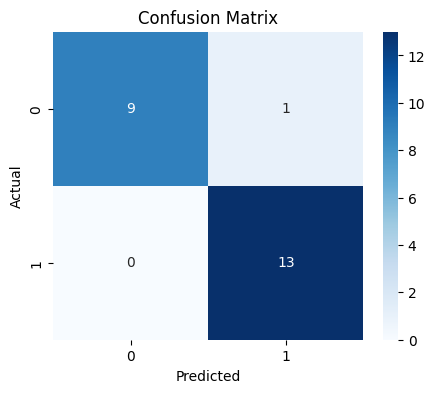

ROC AUC: 0.9231


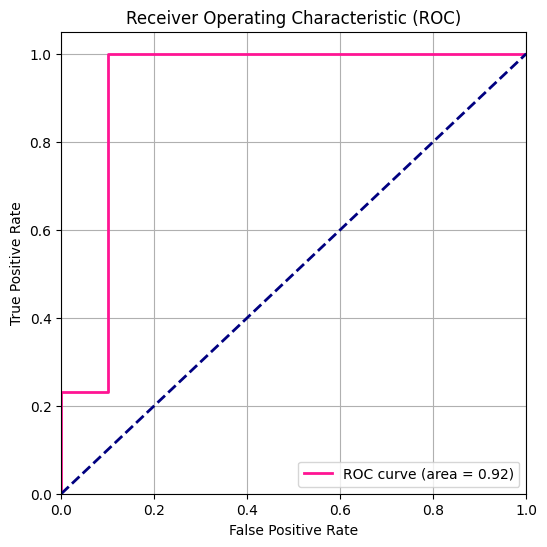

Sensitivity (Recall): 1.0000
Specificity: 0.9000


In [ ]:
rf_model = RandomForestClassifier(
    max_depth=None, 
    max_features=None, 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_estimators=300, 
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


y_probs = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='deeppink', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # True Positive Rate
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # True Negative Rate

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

In [31]:
rf_model = RandomForestClassifier(
    max_depth=None, 
    max_features=None, 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_estimators=300, 
    random_state=42
)
accuracies = []
aucs = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    rf_model.fit(X_train_fold, y_train_fold)
    y_pred = rf_model.predict(X_test_fold)
    y_prob = rf_model.predict_proba(X_test_fold)[:, 1]

    acc = accuracy_score(y_test_fold, y_pred)
    roc = roc_auc_score(y_test_fold, y_prob)
    
    accuracies.append(acc)
    aucs.append(roc)

print(f"\nAverage Accuracy: {np.mean(accuracies)*100:.4f}")
print(f"Average AUC: {np.mean(aucs):.4f}")


Average Accuracy: 90.9804
Average AUC: 0.9839



Top Genes Contributing to the Model:

       Gene  Importance
16      AVG    0.417034
1      NOD2    0.128847
0   ATG16L1    0.085314
6     CARD9    0.082136
3     LACC1    0.064354
7      FUT2    0.061254
14     CCR7    0.051579
5   SLC39A8    0.040456
9     HGFAC    0.037262
2    PTPN22    0.029254


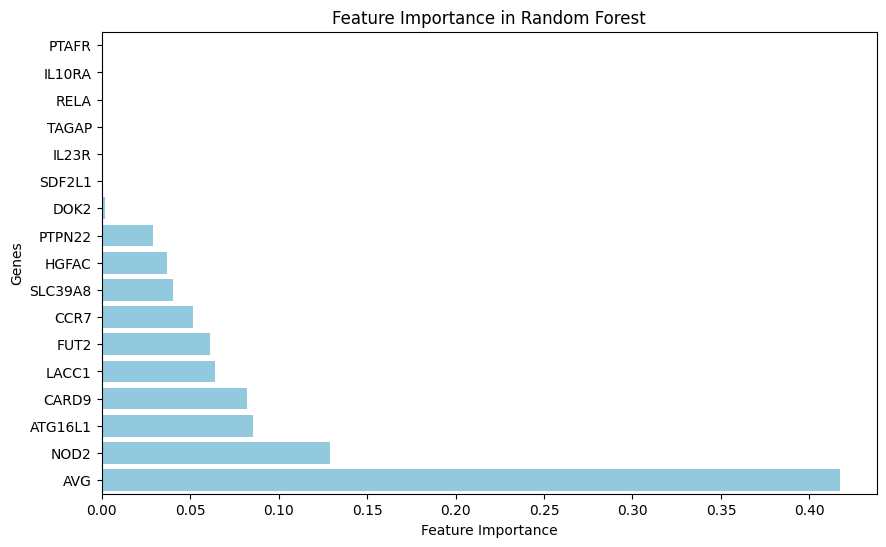

In [ ]:
feature_importance = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({"Gene": X.columns, "Importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

print("\nTop Genes Contributing to the Model:\n")
print(feature_importance_df.head(10))  


plt.figure(figsize=(10, 6))
sns.barplot(y=feature_importance_df["Gene"], x=feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Genes")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()  
plt.show()

PCA

In [41]:
colors = df['label'].map({0: 'blue', 1: 'red'})

In [42]:
from sklearn.decomposition import PCA
pca_df2= PCA(n_components=2)
pca_newpts2 = pca_df2.fit_transform(df)
df = pd.DataFrame(data = pca_newpts2
             , columns = ['principal component 1', 'principal component 2'])
print('Explained variability per principal component: {}'.format(pca_df2.explained_variance_ratio_))

Explained variability per principal component: [0.39156136 0.31711047]


In [44]:
df = pd.concat([df, labels], axis=1)